# References

Code, images: https://github.com/tensorlayer/srgan

In [1]:
import os
import time
import random
import numpy as np
import scipy, multiprocessing
from tensorflow import keras
import tensorflow as tf
import tensorlayer as tl
from tensorlayer.layers import (Input, Conv2d, BatchNorm2d, Elementwise, SubpixelConv2d, Flatten, Dense)
from tensorlayer.models import Model
from IPython.display import Image
from main import get_G, cropImages


# 1 Network
### 1.1 Generator

![Generator.png](Generator.png)
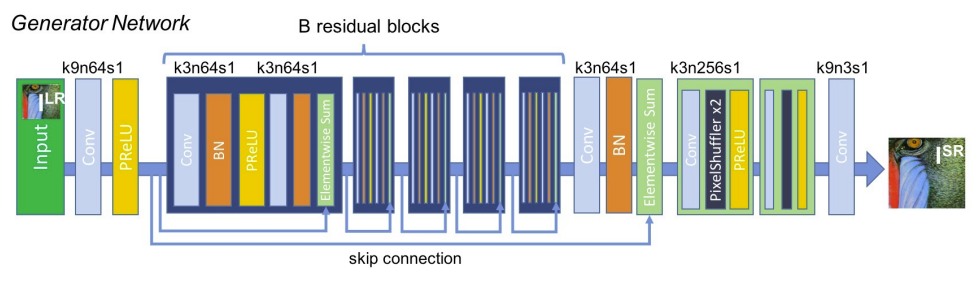

In [ ]:
def get_Generator(input_shape):
    w_init = tf.random_normal_initializer(stddev=0.02)
    g_init = tf.random_normal_initializer(1., 0.02)

    nin = Input(input_shape)

![Input.png](./Input.png)
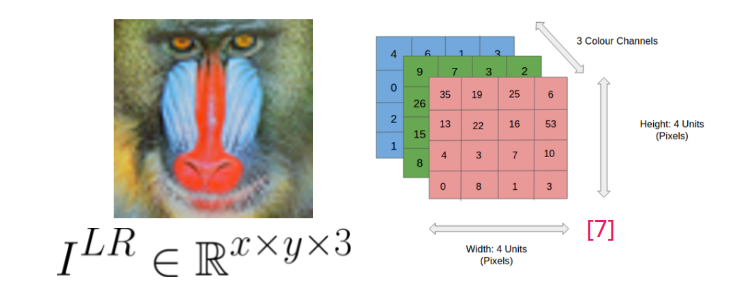

In [ ]:
n = Conv2d(64, (3, 3), (1, 1), act=tf.nn.relu, padding='SAME', W_init=w_init)(nin)
temp = n

<table><tr>
<td><img src="./Convolution.png" alt="Drawing" style="width: 500px;"/> </td>
<td><img src="./PRELU.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

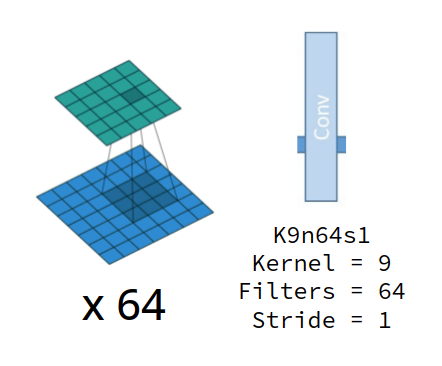

In [ ]:
for i in range(16):
    nn = Conv2d(64, (3, 3), (1, 1), padding='SAME', W_init=w_init, b_init=None)(n)
    nn = BatchNorm2d(act=tf.nn.relu, gamma_init=g_init)(nn)
    nn = Conv2d(64, (3, 3), (1, 1), padding='SAME', W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(gamma_init=g_init)(nn)
    nn = Elementwise(tf.add)([n, nn])
    n = nn

![Generator.png](Generator.png)
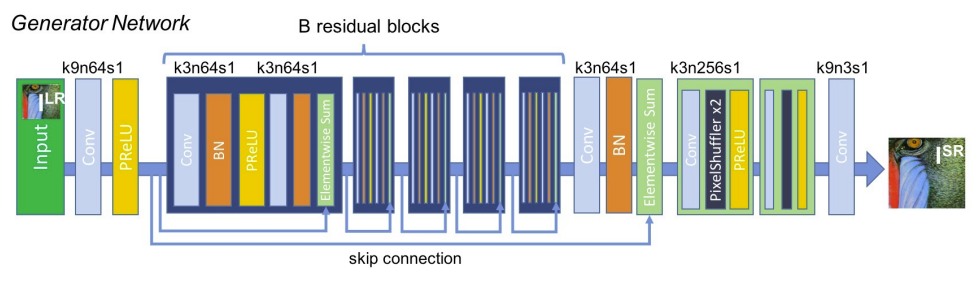

In [ ]:
n = Conv2d(64, (3, 3), (1, 1), padding='SAME', W_init=w_init, b_init=None)(n)
n = BatchNorm2d(gamma_init=g_init)(n)

![Batchnorm.png](Batchnorm.png)
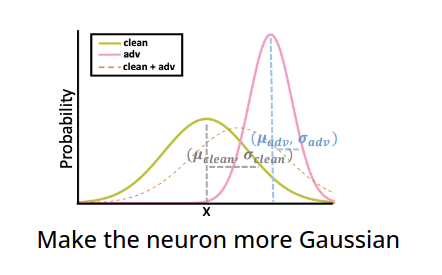

In [ ]:
n = Elementwise(tf.add)([n, temp])


n = Conv2d(256, (3, 3), (1, 1), padding='SAME', W_init=w_init)(n)
n = SubpixelConv2d(scale=2, n_out_channels=None, act=tf.nn.relu)(n)

![PixelShuffle.png](PixelShuffle.png)
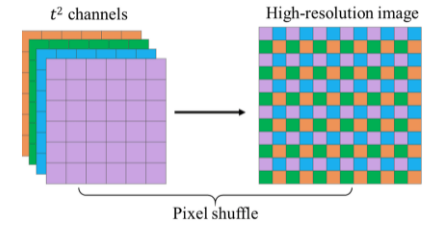

In [ ]:
n = Conv2d(256, (3, 3), (1, 1), act=None, padding='SAME', W_init=w_init)(n)
n = SubpixelConv2d(scale=2, n_out_channels=None, act=tf.nn.relu)(n)

nn = Conv2d(3, (1, 1), (1, 1), act=tf.nn.tanh, padding='SAME', W_init=w_init)(n)
G = Model(inputs=nin, outputs=nn, name="generator")
return G

### 1.2 Discriminator

![Discrim.png](Discrim.png)
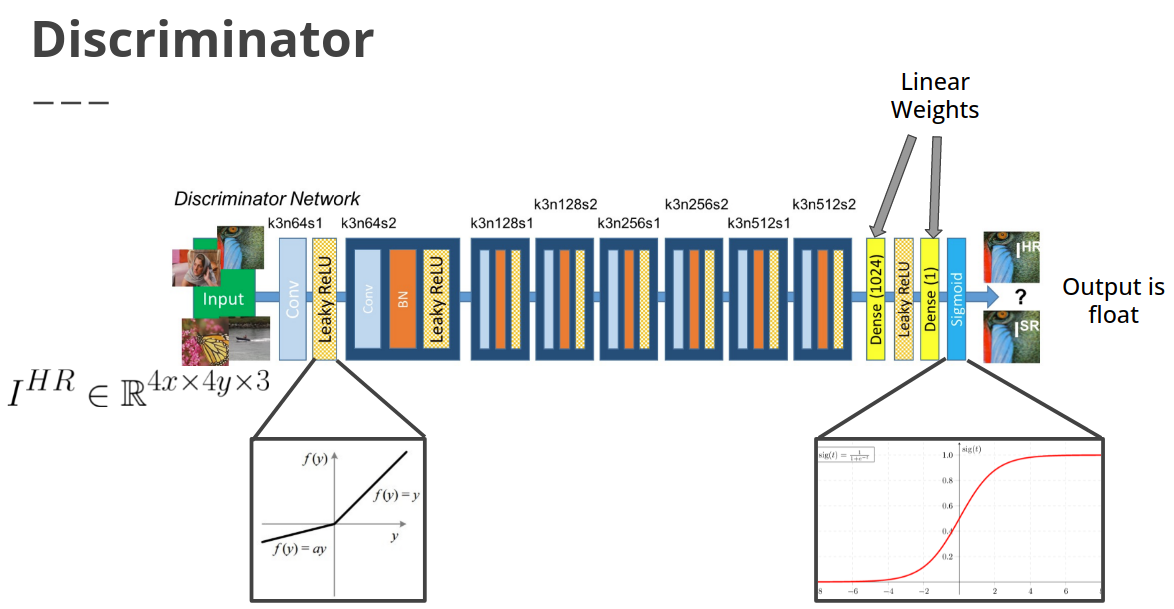

# 2 Training / Evaluation

In [2]:
batch_size = 6  # use 8 if your GPU memory is small, and change [4, 4] in tl.vis.save_images to [2, 4]
lr_init = 1e-4
beta1 = 0.9
## initialize G
n_epoch_init = 1
## adversarial learning (SRGAN)
n_epoch = 1
lr_decay = 0.1
decay_every = int(n_epoch / 2)
shuffle_buffer_size = 128

# create folders to save result images and trained models
save_dir = "samples"
tl.files.exists_or_mkdir(save_dir)
checkpoint_dir = "models"
tl.files.exists_or_mkdir(checkpoint_dir)

## train set location
TRAIN_hr_img_path = 'img/train/hr/'
TRAIN_lr_img_path = 'img/train/lr/'

## test set location
VALID_hr_img_path = 'img/test/hr/'
VALID_lr_img_path = 'img/test/lr/'

def get_train_data():
    # load dataset
    train_hr_img_list = sorted(tl.files.load_file_list(path=TRAIN_hr_img_path, regx='.*.png', printable=False))[0:10]

    train_hr_imgs = tl.vis.read_images(train_hr_img_list, path=TRAIN_hr_img_path, n_threads=32)
        
    # dataset API and augmentation
    def generator_train():
        for img in train_hr_imgs:
            yield img
    def _map_fn_train(img):
        hr_patch = tf.image.random_crop(img, [384, 384, 3])
        hr_patch = hr_patch / (255. / 2.)
        hr_patch = hr_patch - 1.
        hr_patch = tf.image.random_flip_left_right(hr_patch)
        lr_patch = tf.image.resize(hr_patch, size=[96, 96])
        return lr_patch, hr_patch
    train_ds = tf.data.Dataset.from_generator(generator_train, output_types=(tf.float32))
    train_ds = train_ds.map(_map_fn_train, num_parallel_calls=multiprocessing.cpu_count())
    
    train_ds = train_ds.shuffle(shuffle_buffer_size)
    train_ds = train_ds.prefetch(buffer_size=2)
    train_ds = train_ds.batch(batch_size)
        
    return train_ds

def train():
    G = get_G((batch_size, 96, 96, 3))
    D = get_D((batch_size, 384, 384, 3))
   
    VGG = tl.models.vgg19(end_with='pool4', mode='static')

    lr_v = tf.Variable(lr_init) # tf.Variable
    g_optimizer_init = tf.optimizers.Adam(lr_v, beta_1=beta1)
    g_optimizer = tf.optimizers.Adam(lr_v, beta_1=beta1)
    d_optimizer = tf.optimizers.Adam(lr_v, beta_1=beta1)

    G.train()
    D.train()
    VGG.train()

    train_ds = get_train_data()

    ## initialize learning (G)
    n_step_epoch = round(n_epoch_init // batch_size)
    for epoch in range(n_epoch_init):
        for step, (lr_patchs, hr_patchs) in enumerate(train_ds):
            if lr_patchs.shape[0] != batch_size: # if the remaining data in this epoch < batch_size
                break
            step_time = time.time()
            with tf.GradientTape() as tape:
                fake_hr_patchs = G(lr_patchs)
                mse_loss = tl.cost.mean_squared_error(fake_hr_patchs, hr_patchs, is_mean=True)
            grad = tape.gradient(mse_loss, G.trainable_weights)
            g_optimizer_init.apply_gradients(zip(grad, G.trainable_weights))
            print("Epoch: [{}/{}] step: [{}/{}] time: {:.3f}s, mse: {:.3f} ".format(
                epoch, n_epoch_init, step, n_step_epoch, time.time() - step_time, mse_loss))
        if (epoch != 0) and (epoch % 10 == 0):
            tl.vis.save_images(fake_hr_patchs.numpy(), [2, 4], os.path.join(save_dir, 'train_g_init_{}.png'.format(epoch)))

    ## adversarial learning (G, D)
    n_step_epoch = round(n_epoch // batch_size)
    for epoch in range(n_epoch):
        for step, (lr_patchs, hr_patchs) in enumerate(train_ds):
            if lr_patchs.shape[0] != batch_size: # if the remaining data in this epoch < batch_size
                break
            step_time = time.time()
            with tf.GradientTape(persistent=True) as tape:
                fake_patchs = G(lr_patchs)
                logits_fake = D(fake_patchs)
                logits_real = D(hr_patchs)
                feature_fake = VGG((fake_patchs+1)/2.) # the pre-trained VGG uses the input range of [0, 1]
                feature_real = VGG((hr_patchs+1)/2.)
                d_loss1 = tl.cost.sigmoid_cross_entropy(logits_real, tf.ones_like(logits_real))
                d_loss2 = tl.cost.sigmoid_cross_entropy(logits_fake, tf.zeros_like(logits_fake))
                d_loss = d_loss1 + d_loss2
                g_gan_loss = 1e-3 * tl.cost.sigmoid_cross_entropy(logits_fake, tf.ones_like(logits_fake))
                mse_loss = tl.cost.mean_squared_error(fake_patchs, hr_patchs, is_mean=True)
                vgg_loss = 2e-6 * tl.cost.mean_squared_error(feature_fake, feature_real, is_mean=True)
                g_loss = mse_loss + vgg_loss + g_gan_loss
            grad = tape.gradient(g_loss, G.trainable_weights)
            g_optimizer.apply_gradients(zip(grad, G.trainable_weights))
            grad = tape.gradient(d_loss, D.trainable_weights)
            d_optimizer.apply_gradients(zip(grad, D.trainable_weights))
            print("Epoch: [{}/{}] step: [{}/{}] time: {:.3f}s, g_loss(mse:{:.3f}, vgg:{:.3f}, adv:{:.3f}) d_loss: {:.3f}".format(
                epoch, n_epoch_init, step, n_step_epoch, time.time() - step_time, mse_loss, vgg_loss, g_gan_loss, d_loss))

        # update the learning rate
        if epoch != 0 and (epoch % decay_every == 0):
            new_lr_decay = lr_decay**(epoch // decay_every)
            lr_v.assign(lr_init * new_lr_decay)
            log = " ** new learning rate: %f (for GAN)" % (lr_init * new_lr_decay)
            print(log)

        if (epoch != 0) and (epoch % 10 == 0):
            tl.vis.save_images(fake_patchs.numpy(), [2, 4], os.path.join(save_dir, 'train_g_{}.png'.format(epoch)))
            G.save_weights(os.path.join(checkpoint_dir, 'g.h5'))
            D.save_weights(os.path.join(checkpoint_dir, 'd.h5'))
   

def evaluate():
    ###====================== PRE-LOAD DATA ===========================###
    valid_hr_img_list = sorted(tl.files.load_file_list(path=VALID_hr_img_path, regx='.*.png', printable=False))
    valid_lr_img_list = sorted(tl.files.load_file_list(path=VALID_lr_img_path, regx='.*.png', printable=False))

    valid_lr_imgs = tl.vis.read_images(valid_lr_img_list, path=VALID_lr_img_path, n_threads=32)
    valid_hr_imgs = tl.vis.read_images(valid_hr_img_list, path=VALID_hr_img_path, n_threads=32)

    ###========================== DEFINE MODEL ============================###
    imid = 0
    valid_lr_img = valid_lr_imgs[imid]
    valid_hr_img = valid_hr_imgs[imid]
    valid_lr_img = (valid_lr_img / 127.5) - 1  # rescale to ［－1, 1]

    G = get_G([1, None, None, 3])
   
    G.load_weights(os.path.join(checkpoint_dir, 'g.h5'))
    
    G.eval()

    valid_lr_img = np.asarray(valid_lr_img, dtype=np.float32)
    valid_lr_img = valid_lr_img[np.newaxis,:,:,:]
    size = [valid_lr_img.shape[1], valid_lr_img.shape[2]]

    out = G(valid_lr_img).numpy()

    print("LR size: %s /  generated HR size: %s" % (size, out.shape))  # LR size: (339, 510, 3) /  gen HR size: (1, 1356, 2040, 3)
    print("[*] save images")
    tl.vis.save_image(out[0], os.path.join(save_dir, 'valid_gen.png'))
    tl.vis.save_image(valid_lr_img[0], os.path.join(save_dir, 'valid_lr.png'))
    tl.vis.save_image(valid_hr_img, os.path.join(save_dir, 'valid_hr.png'))

[TL] [!] samples exists ...
[TL] [!] models exists ...


In [ ]:
evaluate()
cropImages()

# 3 Results

<table><tr>
<td>Upscaled Image <img src="./samples/valid_gen_crop.png" alt="Drawing" style="width: 1000px;"/> </td>
<td>Low Resolution <img src="./samples/valid_lr_crop.png" alt="Drawing" style="width: 1000px;"/> </td>
</tr></table>
